# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.xlim(-10.5, 10.5)
        plt.ylim(-10.5, 10.5)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [105]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

<IPython.core.display.Javascript object>


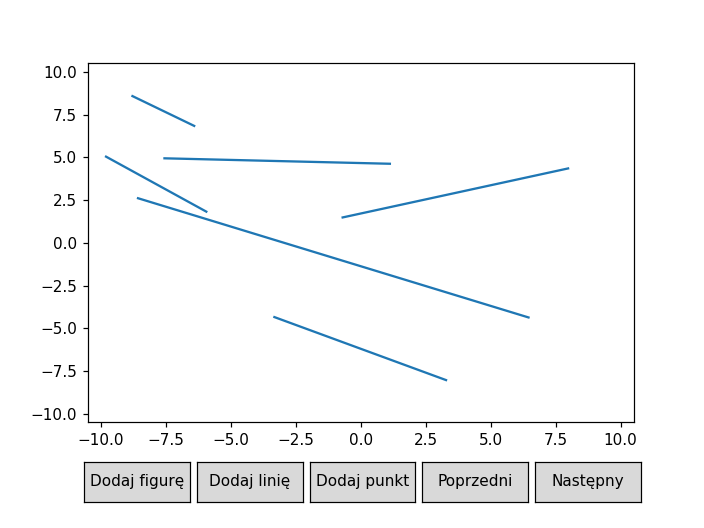

In [106]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [119]:
plot1.get_added_elements().lines[0].get_collection().get_segments()
lines = [ x.tolist() for x in plot1.get_added_elements().lines[0].get_collection().get_segments() ]
# lines = [[[-4.277532762096774, 4.541073069852942]
#           ,[-9.10414566532258, -3.822897518382355]],
#  [[-1.99124243951613, 0.809455422794116],
#   [-0.12833921370967794, -3.6942210477941195]],
#  [[1.31117691532258, -1.635397518382355],
#   [1.98859627016129, -0.2199563419117645]],
#  [[3.597467237903224, -4.20892693014706],
#   [8.339402721774192, 4.798426011029413]]]
lines

[[[-8.82870243441674, 8.615035393658808],
  [-6.373057273126417, 6.813564805423514]],
 [[-9.844831466674805, 5.0764324524823365],
  [-5.907331466674804, 1.7951824524823365]],
 [[-7.600879853771579, 4.947755981894101],
  [1.1632330494542291, 4.626064805423514]],
 [[-8.617008886029643, 2.6315795113058655],
  [6.497910468809067, -4.381288135752959]],
 [[-3.3670088860296428, -4.316949900458841],
  [3.3225072430026152, -8.048567547517665]],
 [[-0.7420088860296428, 1.4734912760117496],
  [8.022104017196163, 4.368711864247043]]]

In [108]:
def det2d( a, b, c ):
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c
    return a_x*b_y + a_y*c_x + b_x*c_y - a_x*c_y - a_y*b_x - b_y*c_x


In [112]:
def eq(a,b):
    eps = 10**-9
    return abs(a-b) <= eps


def cal_a(l):
    p1,p2 = l
    if p1 > p2:
        p1,p2=p2,p1
    return (p2[1]-p1[1])/(p2[0]-p1[0])

def cal_b(l):
    return l[1][1]-cal_a(l)*l[1][0]

def toLineFunction(l):
    a = cal_a(l)
    b = cal_b(l)
    return lambda x : a*x + b
def get_b(f):
    return f(0)
def get_a(f):
    return f(1) - f(0)
        
class Trapezoid:
    def __init__(self, top, bottom, leftp, rigthp):
        self.top = top
        self.bottom = bottom
        self.leftp = leftp
        self.rigthp = rigthp
        self.left_up = None    
        self.left_down = None   
        self.right_up = None   
        self.right_down = None
        self.node = None

    def copyConnections(self,other):
        self.left_up = other.left_up
        self.left_down = other.left_down
        self.right_up = other.right_up
        self.right_down = other.right_down
    def copyConnectionsRight(self,other):
        self.right_up = other.right_up
        self.right_down = other.right_down
    def copyConnectionsLeft(self,other):
        self.left_up = other.left_up
        self.left_down = other.left_down
        
    def contains(self,point):
        x,y = point
        if (self.top(x) > y or eq(self.top(x),y) ) and (self.bottom(x) < y or eq(self.bottom(x),y)):
            if (self.leftp[0] < x or eq(self.leftp[0],x)) and (self.rigthp[0] > x or eq(self.rigthp[0],x)):
                return True
        return False
    
    def compareTop(self,other):
        return eq(get_a(self.top),get_a(other.top)) and eq(get_b(self.top),get_b(other.top))
    def compareBottom(self,other):
        return eq(get_a(self.bottom),get_a(other.bottom)) and eq(get_b(self.bottom),get_b(other.bottom))    
    
    def points(self):
        lx = self.leftp[0]
        rx = self.rigthp[0]
        return [[lx, self.top(lx)], [lx,self.bottom(lx)], [rx, self.bottom(rx)], [rx,self.top(rx)] ]
    
    def lines(self):
        p = self.points()
        return [ [p[i],p[(i+1)%4]] for i in range(4) ]
          
    def updateLU(self):
        if(self.left_up != None):
            self.left_up.right_up = self
    def updateLD(self):
        if(self.left_down != None):
            self.left_down.right_down = self
    def updateRU(self):
        if(self.right_up != None):
            self.right_up.left_up = self
    def updateRD(self):
        if(self.right_down != None):
            self.right_down.left_down = self 
    def updateALL(self):
        self.updateLU()
        self.updateLD()
        self.updateRU()
        self.updateRD()
            
            
    def cutLeft(self,point):
        t = Trapezoid(self.top,self.bottom,self.leftp,point)
        t.left_up = self.left_up
        t.left_down = self.left_down
        t.updateLU()
        t.updateLD()
        return t
        
    def cutRigth(self,point):
        t =  Trapezoid(self.top,self.bottom,point,self.rigthp)
        t.right_up = self.right_up
        t.right_down = self.right_down
        t.updateRU()
        t.updateRD()
        return t
    
class Node:
    def __init__(self, val):
        self.value = val
        self.children = []
        val.node = self
        
class Graph:
    def __init__(self, root):
        self.root = root
    def find(self,point):
        return self._find_r(self.root,point)
        
    def _find_r(self, node, point):
        if len(node.children) == 0:
            return node
        for I in node.children:
            if I.value.contains(point):
                return self._find_r(I, point)
        return node
    
    def path(self, line):
        p1,p2 = line
        func = toLineFunction(line)
        curr = self.find(p1).value
        l = [curr]
        while curr != None and not curr.contains(p2):
            if func(curr.rigthp[0]) > curr.rigthp[1]:
                curr = curr.right_up
            else:
                curr = curr.right_down
            l.append(curr)
        return l

In [113]:
lines = [[[-4.277532762096774, 4.541073069852942]
          ,[-9.10414566532258, -3.822897518382355]],
 [[-1.99124243951613, 0.809455422794116],
  [-0.12833921370967794, -3.6942210477941195]],
 [[1.31117691532258, -1.635397518382355],
  [1.98859627016129, -0.2199563419117645]],
 [[3.597467237903224, -4.20892693014706],
  [8.339402721774192, 4.798426011029413]]]
lines += [[[-8,-5],[9,-5]]]
lines += [[[-6,6],[6,6]]]
lines += [[[-7,8],[7,8]]]

In [120]:
boundary = Trapezoid( lambda x : 10, lambda x : -10 , [-10,10], [10,10] )
D = Graph(Node(boundary))
boundary.contains([-5.0001,10])

def lowerP( p, func ):
    x = p[0]
    y = p[1]
    if y < func(x):
        return p
    else:
        return [x,func(x)]
    
def upperP( p, func ):
    x = p[0]
    y = p[1]
    if y > func(x):
        return p
    else:
        return [x,func(x)]

print(lines)
def create_graph(lines):
    for line in lines:
        p1,p2 = sorted(line)
        curr = D.find(p1)
        currT = curr.value
        if curr.value.contains(p1) and curr.value.contains(p2):
            t1 = currT.cutLeft(p1)
            t2 = currT.cutRigth(p2)
            t3 = Trapezoid(currT.top,toLineFunction(line),p1,p2)
            t4 = Trapezoid(toLineFunction(line),currT.bottom,p1,p2)
            t3.left_up = t1
            t3.updateLU()
            t3.right_up = t2
            t3.updateRU()
            t4.left_down = t1
            t4.updateLD()
            t4.right_down = t2
            t4.updateRD()
            curr.children.append(Node(t1))
            curr.children.append(Node(t2))
            curr.children.append(Node(t3))
            curr.children.append(Node(t4))
        else:
    #         połączyć je
            func = toLineFunction(line)
            segment = D.path(sorted(line))
            print(segment)
            uppers = []
            lowers = []
            fst = segment[0]
            lst = segment[-1]
            t1 = currT.cutLeft(p1)
            t13 = Trapezoid(fst.top,func ,p1 , upperP(fst.rigthp,func))
            t14 = Trapezoid(func,fst.bottom,p1, lowerP(fst.rigthp,func))
            t13.copyConnections(fst)
            t14.copyConnections(fst)
            t13.left_up = t1
            t13.updateLU()
            t14.left_down = t1
            t14.updateLD()
            t2 = segment[-1].cutRigth(p2)
            t23 = Trapezoid(lst.top,func, upperP(lst.leftp,func),p2)
            t24 = Trapezoid(func,lst.bottom,lowerP(lst.leftp,func),p2)
            t23.copyConnections(lst)
            t24.copyConnections(lst)
            t23.right_up = t2
            t23.updateRU()
            t24.right_down = t2
            t24.updateRD()
            fst.node.children.append(Node(t1))
            lst.node.children.append(Node(t2))
            t13.node = fst.node
            t14.node = fst.node
            t23.node = lst.node
            t24.node = lst.node
            uppers.append(t13)
            lowers.append(t14)

            for P in segment[1:-1]:
                x1 = P.leftp[0]
                y1 = P.leftp[1]
                x2 = P.rigthp[0]
                y2 = P.rigthp[1]
                if func(x1) < y1:
                    leftPoint = P.leftp
                else:
                    leftPoint = [x1,func(x1)]
                if func(x2) < y2:
                    rightPoint = P.rigthp
                else:
                    rightPoint = [x2,func(x2)]
                tUpper = Trapezoid(P.top,func,leftPoint,rightPoint)
                tUpper.node = P.node
                tUpper.copyConnections(P)
                if func(x1) > y1:
                    leftPoint = P.leftp
                else:
                    leftPoint = [x1,func(x1)]
                if func(x2) > y2:
                    rightPoint = P.rigthp
                else:
                    rightPoint = [x2,func(x2)]
                tLower = Trapezoid(func,P.bottom,rightPoint,rightPoint)
                tLower.node = P.node
                tLower.copyConnections(P)
                uppers.append(tUpper)
                lowers.append(tLower)


            uppers.append(t23)
            lowers.append(t24)
            n = len(lowers)

            for i in range(1,n):
                uppers[i].left_down = uppers[i-1]
                uppers[i].left_down.updateLD()
                lowers[i].left_up = lowers[i-1]
                lowers[i].left_up.updateLU()
            
            for i in range(n-1):
                if( lowers[i].compareBottom(lowers[i+1]) ):
                    lowers[i].rigthp = lowers[i+1].rigthp
                    lowers[i].copyConnectionsRight(lowers[i+1])
                    lowers[i+1] = lowers[i]
                if( uppers[i].compareTop(uppers[i+1]) ):
                    uppers[i].rigthp = uppers[i+1].rigthp
                    uppers[i].copyConnectionsRight(uppers[i+1])
                    uppers[i+1] = uppers[i]
            for i in range(0,n):
                uppers[i].updateALL()
                lowers[i].updateALL()
            print(n)
            print(lowers.__len__())
            print(uppers.__len__())
            print([ x.leftp for x in uppers if x != None ])
            print(uppers[-1].left_up)
            [ segment[i].node.children.append(Node(x)) for (i,x) in enumerate(uppers) if x != None ]
            [ segment[i].node.children.append(Node(x)) for (i,x) in enumerate(lowers) if x != None ]
    #         [ x.node.children.append(Node(x)) for x in lowers if x != None ]
    #         curr.children.extend([ Node(x) for x in uppers if x != None ])
    #         curr.children.extend([ Node(x) for x in lowers if x != None ])    

create_graph(lines)

[[[-8.82870243441674, 8.615035393658808], [-6.373057273126417, 6.813564805423514]], [[-9.844831466674805, 5.0764324524823365], [-5.907331466674804, 1.7951824524823365]], [[-7.600879853771579, 4.947755981894101], [1.1632330494542291, 4.626064805423514]], [[-8.617008886029643, 2.6315795113058655], [6.497910468809067, -4.381288135752959]], [[-3.3670088860296428, -4.316949900458841], [3.3225072430026152, -8.048567547517665]], [[-0.7420088860296428, 1.4734912760117496], [8.022104017196163, 4.368711864247043]]]
[<__main__.Trapezoid object at 0x000001E141944640>, <__main__.Trapezoid object at 0x000001E13E61ADA0>, <__main__.Trapezoid object at 0x000001E141944FD0>]
3
3
3
[[-9.844831466674805, 5.0764324524823365], [-8.82870243441674, 8.615035393658808], [-6.373057273126417, 6.813564805423514]]
[<__main__.Trapezoid object at 0x000001E13E61A9E0>, <__main__.Trapezoid object at 0x000001E13E618EB0>, <__main__.Trapezoid object at 0x000001E13E61A7A0>]
3
3
3
[[-7.600879853771579, 4.947755981894101], [-6

[[-9, 7.4], [-5, 5.5]]
[<__main__.Trapezoid object at 0x000001E13E619DB0>, <__main__.Trapezoid object at 0x000001E13E8B3F10>, <__main__.Trapezoid object at 0x000001E13E8B05B0>]
[-8.82870243441674, 8.615035393658808]
[-9.844831466674805, 5.0764324524823365]

[-6.373057273126417, 6.813564805423514]
[-7.600879853771579, 4.947755981894101]

[1.1632330494542291, 4.626064805423514]
[-6.373057273126417, 6.813564805423514]



<IPython.core.display.Javascript object>


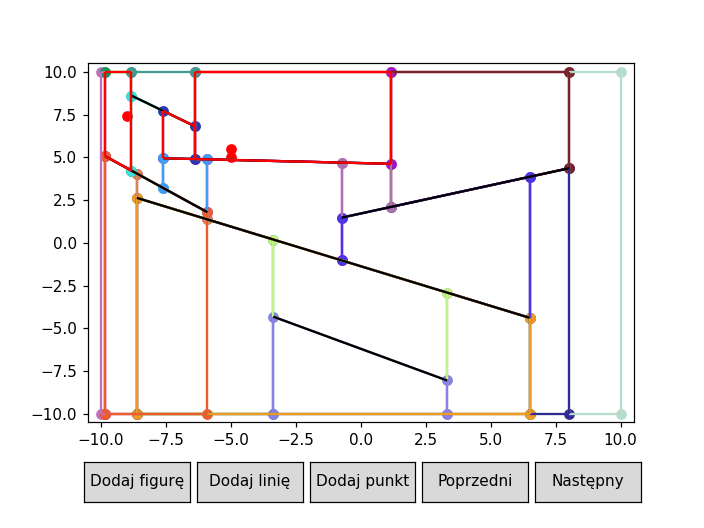

In [130]:
allLines = []
allPoints = []
# def collect(node):
#     allPoints.extend(node.value.points())
#     if len(node.children) > 0:
#         for I in node.children:
#             collect(I)
# def collectPoints(node):
#     allPoints.append( PointsCollection( node.value.points(), color=np.random.rand(3,) ) )
#     if len(node.children) > 0:
#         for I in node.children:
#             collect(I)
# collectPoints(D)


# def collectLines(node):
#     allLines.append( LinesCollection( node.value.lines(), color=np.random.rand(3,) ) )
#     if len(node.children) > 0:
#         for I in node.children:
#             collectLines(I)
# collectLines(D)

def collect(node):
    c = np.random.rand(3,)
    if len(node.children) > 0:
        for I in node.children:
            collect(I)
    else:
        allPoints.append( PointsCollection( node.value.points(), color=c ) )
        allLines.append( LinesCollection( node.value.lines(), color=c ) )
collect(D.root)

# print(allPoints)
# for I in allPoints:
#     print(I)
# plot = Plot(points=[PointsCollection(allPoints), PointsCollection(find(D,[6,6]).value.points(),color="orange")],
#             lines=[LinesCollection(lines,color="red")]
#            )

expPoint1 = [-8,-5]
expPoint2 = [9,-5]
expPoint1 = [-9,8.4]
expPoint2 = [9,8.4]
expPoint1 = [-9,7.4]
expPoint2 = [-5,5.5]
expLine = [expPoint1,expPoint2]
print(expLine)

path = D.path(expLine)
print(path)

h = [ LinesCollection(D.find(expPoint1).value.lines(),color="red")]
# h = [ LinesCollection( x.lines() , color=np.random.rand(3,) ) for x in path ]
h = [ LinesCollection(D.find([0,9]).value.lines(),color="red")]
tmp = []
for I in path:
    if I != None:
        tmp.extend(I.lines())
        print(I.rigthp)
        print(I.leftp)
        print()
#         if I.right_down != None:
#             print(I.right_down.rigthp)
h = [ LinesCollection( tmp ,color="red")]
pppppp = [-5,5]
# h = [ LinesCollection(D.find(pppppp).value.lines(),color="red") ]
# h = [ LinesCollection( x.value.lines() , color=np.random.rand(3,) ) for x in find(D,expPoint).children ]
# h = [ LinesCollection(find(D,expPoint).children[2].value.lines()) ]
# print(find(D,expPoint).children[2].value.leftp)

plot = Plot(points=allPoints+  [PointsCollection([expPoint1,expPoint2]+ [pppppp],color="red")] ,
            lines=
            allLines
            + [LinesCollection(lines,color="black")]
            + h
           )
plot.draw()

# +[LinesCollection(find(D,expPoint1).value.lines(),color="red")]

In [40]:
lines = [[[-8.235960498932869, 3.2457163193646608],
  [-6.796444369900611, -0.7432542688706327]],
 [[-3.959750821513513, -1.193621915929457],
  [-2.012170176352223, 1.9589516134823093]],
 [[1.3749265978413252, 2.924025142894074],
  [4.762023372034875, -0.4859013276941617]],
 [[-8.617008886029643, -2.2230336806353392],
  [8.27613627526068, -8.785533680635341]]
        ]
lines

[[[-8.235960498932869, 3.2457163193646608],
  [-6.796444369900611, -0.7432542688706327]],
 [[-3.959750821513513, -1.193621915929457],
  [-2.012170176352223, 1.9589516134823093]],
 [[1.3749265978413252, 2.924025142894074],
  [4.762023372034875, -0.4859013276941617]],
 [[-8.617008886029643, -2.2230336806353392],
  [8.27613627526068, -8.785533680635341]]]

In [79]:
[[[-8.82870243441674, 8.615035393658808],
  [-6.373057273126417, 6.813564805423514]],
 [[-9.844831466674805, 5.0764324524823365],
  [-5.907331466674804, 1.7951824524823365]],
 [[-7.600879853771579, 4.947755981894101],
  [1.1632330494542291, 4.626064805423514]],
 [[-8.617008886029643, 2.6315795113058655],
  [6.497910468809067, -4.381288135752959]],
 [[-3.3670088860296428, -4.316949900458841],
  [3.3225072430026152, -8.048567547517665]],
 [[-0.7420088860296428, 1.4734912760117496],
  [8.022104017196163, 4.368711864247043]]]

expPoint1 = [-9,7.4]
expPoint2 = [-5,5.5]

SyntaxError: invalid syntax (3555235510.py, line 1)